In [ ]:
%pip install resampy
# %pip install numpy==1.23.5
%pip install soundata

import librosa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, shutil

In [12]:
import enum

class FeatureType(enum.Enum):
    Spectr = 0
    Mel = 1

# feature_type = FeatureType.Spectr
feature_type = FeatureType.Mel

dataset_path = os.path.join(os.getcwd(), "dataset")
serailized_dataset_path = os.path.join(os.getcwd(), "dataset_serialized")
serialized_data_dir = ""
coefficient_count = 0
if (feature_type == FeatureType.Spectr):
    coefficient_count = 128
    serialized_data_dir = os.path.join(serailized_dataset_path, "spectr")
elif (feature_type == FeatureType.Mel):
    coefficient_count = 40
    serialized_data_dir = os.path.join(serailized_dataset_path, "mel")

In [2]:
update_dataset = False

#### Загрузка датасета
Для работы нейросети необходимо использовать обработанные массивы (метрики), которые будут поданы на её вход. Для загрузки датасета предварительно запустите следующий блок.

Загрузка датасета не повлияет на предобработанные метрики. Для этого запустите отдельный блок, который удалит папку `/serialized_dataset`
После этого будет возможность пересоздать "метрики" для нейронной сети, которые перезапишут предзагруженные.

In [ ]:
import soundata

if (update_dataset):
  if (os.path.isdir(dataset_path)):
    shutil.rmtree(dataset_path)

  dataset = soundata.initialize("urbansound8k", data_home=dataset_path)
  dataset.download()
  dataset.validate()

In [15]:
def get_features(file_name):
    ## Чтение в 2-канальном режиме
    ## В последствии если аудио не может быть прочитано в двухканальном режиме, отбрасываем
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', mono=False)
    if (feature_type == FeatureType.Spectr):
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        features = librosa.power_to_db(S=spectrogram, ref=1.0)
    elif (feature_type == FeatureType.Mel):
        features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=coefficient_count)

    return features.T

def reread_sound():
  return pd.read_csv(dataset_path + "/metadata/UrbanSound8K.csv")

reread_sound()

slice_file_name    fsID       start         end  salience  fold  \
0       100032-3-0-0.wav  100032    0.000000    0.317551         1     5   
1     100263-2-0-117.wav  100263   58.500000   62.500000         1     5   
2     100263-2-0-121.wav  100263   60.500000   64.500000         1     5   
3     100263-2-0-126.wav  100263   63.000000   67.000000         1     5   
4     100263-2-0-137.wav  100263   68.500000   72.500000         1     5   
...                  ...     ...         ...         ...       ...   ...   
8727     99812-1-2-0.wav   99812  159.522205  163.522205         2     7   
8728     99812-1-3-0.wav   99812  181.142431  183.284976         2     7   
8729     99812-1-4-0.wav   99812  242.691902  246.197885         2     7   
8730     99812-1-5-0.wav   99812  253.209850  255.741948         2     7   
8731     99812-1-6-0.wav   99812  332.289233  334.821332         2     7   

      classID             class  
0           3          dog_bark  
1           2  children_playing  
2           2  children_playing  
3           2  children_playing  
4           2  children_playing  
...       ...               ...  
8727        1          car_horn  
8728        1          car_horn  
8729        1          car_horn  
8730        1          car_horn  
8731        1          car_horn  

[8732 rows x 8 columns]

In [3]:
def load_features(metadata):
    feature_list = []
    classes_list = []
    ## На основе данных
    max_audio_duration = 173
    total_quantity = 0
    for index_num, row in tqdm(metadata.iterrows()):
        file_name = os.path.join(os.path.join(dataset_path, "audio"),'fold'+str(int(row["fold"]))+'/',str(row["slice_file_name"]))
        class_label = row["class"]
        data = get_features(file_name)
        if (len(data.shape) < 3):
            print("Audio is loaded in mono format:",file_name, class_label)
            continue

        extra_shape = max_audio_duration-data.shape[0]
        if (extra_shape > 0):
            try:
                new_data = np.append(data, np.zeros(shape=(extra_shape, coefficient_count, 2), dtype=float), axis=0)
                data = new_data
            except:
                print(file_name, data.shape)
                continue

        total_quantity += 1
        feature_list.append(data)
        classes_list.append(class_label)

    print(f"Correctly parsed: {total_quantity} files")
    return feature_list, classes_list

def save_features(save_folder, features, classes):
    if (not os.path.isdir(save_folder)): os.mkdir(save_folder)
    np.save(os.path.join(save_folder, "features"), features)
    np.save(os.path.join(save_folder, "classes"), classes)

#### Перебор метрик
Для ускорения работы в программе используются предрасчитанные метрики для обоих типов алгоритмов. 
Для создания метрик вам необходимо иметь предзагруженный датасет.
Как только метрики загружены на локальной машине пересчитывать их необязательно - для этого необходимо взвести флаг `update_metrics` в значение `False`.

In [9]:
# update_metrics = True
## Uncomment below to disable metrics update
update_metrics = False

In [13]:
metadata = reread_sound()

if (update_metrics and (not os.path.isdir(dataset_path))):
    raise Warning(f"Please download dataset into {dataset_path} folder before extracting features.")

already_serialized = os.path.isdir(serialized_data_dir)
features_list = []
classes_list = []
if (not update_metrics):
    if (already_serialized):
        feature_list = np.load(os.path.join(serialized_data_dir, "features.npy"))
        classes_list = np.load(os.path.join(serialized_data_dir, "classes.npy"))
    else:
        raise Warning(f"Serialized data in {serialized_data_dir} folder is not found. Update metrics or fix naming.")
elif (not os.path.isdir(dataset_path)):
    raise Warning(f"Please download dataset into {dataset_path} folder before extracting features.")
else:
    print(f'Total: {metadata.shape[0]} audio files')
    print("Recreating metrics...")
    feature_list, classes_list = load_features(metadata)

    if (not os.path.isdir(serailized_dataset_path)):
        os.mkdir(serailized_dataset_path)
    elif (os.path.isdir(serialized_data_dir)):
        shutil.rmtree(serialized_data_dir)
        os.mkdir(serialized_data_dir)
    
    save_features(serialized_data_dir, feature_list, classes_list)

In [14]:
x = np.array(feature_list)
print(x.shape)
classes = np.array(classes_list)

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(classes))
print(y.shape)
### Количество классов
classes_quantity = y.shape[1]

(7993, 173, 40, 2)
(7993, 10)


In [ ]:
### Формируем тестовый и обучающий фрагменты
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.1
# если хочется получать одно и тоже, random_state=0
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size = TEST_SIZE, random_state=None)

In [9]:
from tensorflow import keras
model = keras.Sequential(layers=[
        keras.layers.InputLayer(shape=x[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu, name="Conv_1"),
        keras.layers.MaxPooling2D(name="MaxPooling_1"),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu, name="Conv_2"),
        keras.layers.MaxPooling2D(name="MaxPooling_2"),
        keras.layers.Flatten(name="Flatten"), # this layer "converts matrix to single array"
        keras.layers.Dropout(0.5, name="Dropout"),
        keras.layers.Dense(64, activation=keras.activations.relu, name="Dense_1"),
        keras.layers.Dense(classes_quantity, activation=keras.activations.softmax, name="Dense_final")
    ], name ="Convolutional_Model")
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

# keras.utils.plot_model(model, rankdir="TB", show_shapes=True, show_layer_names=False)

Model: "Convolutional_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                 │ (None, 173, 40, 16)    │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_1 (MaxPooling2D)     │ (None, 86, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 86, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_2 (MaxPooling2D)     │ (None, 43, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 13760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 13760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │       880,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_final (Dense)             │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 886,298 (3.38 MB)

 Trainable params: 886,298 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
BATCH_SIZE = 64
EPOCHS = 25

# Тренировка модели
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=x_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

0.6087680459022522
0.8012499809265137


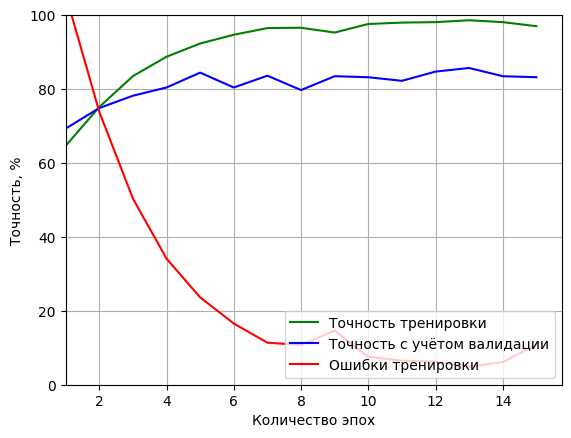

In [11]:
## Проверка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(x_test,y_test,verbose=0)
print(test_loss)
print(test_accuracy)

plt.plot(history.epoch, [val*100 for val in history.history['accuracy']], "g", label='Точность тренировки')
plt.plot(history.epoch, [val*100 for val in history.history['val_accuracy']], "b", label='Точность с учётом валидации')
plt.plot(history.epoch, [val*100 for val in history.history['loss']], "r", label='Ошибки тренировки')
plt.grid(visible=True)
plt.xlabel('Количество эпох')
plt.ylabel('Точность, %')
plt.ylim([0, 100])
plt.xlim(left=True)
plt.legend(loc='lower right')

### Тестирование на случайных данных

In [15]:
## Данные не должны входить в обучаемые, для этого используем предварительно отделенные
el_count = len(y_test)
scaled_y = np.argmax(y_test, axis=1)
test_classes = labelencoder.inverse_transform(scaled_y)
original_labels = [classname.item() for classname in test_classes]
print(f"Данные для теста, ожидаемые классы: ({el_count} шт.)\n", original_labels[0:round(el_count/2)], "\n", original_labels[round(el_count/2):el_count])

predict_x = model.predict(x_test)
predicted_classes = np.argmax(predict_x, axis=1)
labels = [labelencoder.inverse_transform([classValue]).item() for classValue in predicted_classes]
print("Результат работы нейросети: определены классы\n", labels[0:round(el_count/2)], "\n", labels[round(el_count/2):el_count])

mistakes = 0
quantity = len(original_labels)
for i in range(0, quantity):
  if (original_labels[i] != labels[i]):
    mistakes += 1
print(f"Распознано {el_count - mistakes} из {el_count} классов. Соответствие: {round((quantity - mistakes) / quantity * 100)}%")

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(scaled_y, predicted_classes)

axis_labels = list(dict.fromkeys(original_labels + labels))
cm_display = ConfusionMatrixDisplay(cm, display_labels=axis_labels).plot()

Данные для теста, ожидаемые классы: (800 шт.)
 ['street_music', 'engine_idling', 'dog_bark', 'children_playing', 'children_playing', 'siren', 'children_playing', 'dog_bark', 'children_playing', 'children_playing', 'air_conditioner', 'gun_shot', 'dog_bark', 'dog_bark', 'jackhammer', 'street_music', 'jackhammer', 'children_playing', 'children_playing', 'car_horn', 'air_conditioner', 'air_conditioner', 'engine_idling', 'dog_bark', 'children_playing', 'engine_idling', 'siren', 'gun_shot', 'air_conditioner', 'children_playing', 'dog_bark', 'siren', 'dog_bark', 'car_horn', 'children_playing', 'children_playing', 'drilling', 'drilling', 'children_playing', 'car_horn', 'children_playing', 'siren', 'jackhammer', 'jackhammer', 'dog_bark', 'street_music', 'children_playing', 'drilling', 'drilling', 'air_conditioner', 'jackhammer', 'engine_idling', 'siren', 'children_playing', 'siren', 'dog_bark', 'siren', 'children_playing', 'drilling', 'air_conditioner', 'gun_shot', 'air_conditioner', 'air_condi